In [1]:
!git clone https://github.com/google-research/omniglue.git
!cd omniglue
!pip install -e .

# Download to ./models/ dir.
!mkdir models
!cd models

# SuperPoint.
!git clone https://github.com/rpautrat/SuperPoint.git
!mv SuperPoint/pretrained_models/sp_v6.tgz . && rm -rf SuperPoint
!tar zxvf sp_v6.tgz && rm sp_v6.tgz

# DINOv2 - vit-b14.
!wget https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth

# OmniGlue.
!wget https://storage.googleapis.com/omniglue/og_export.zip
!unzip og_export.zip && rm og_export.zip

Cloning into 'omniglue'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 103 (delta 42), reused 38 (delta 38), pack-reused 49 (from 1)
Receiving objects: 100% (103/103), 11.76 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Cloning into 'SuperPoint'...
remote: Enumerating objects: 1621, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1621 (delta 16), reused 21 (delta 8), pack-reused 1575 (from 1)
Receiving objects: 100% (1621/1621), 549.39 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (1081/1081), done.
Updating files: 100% (83/83), done.
sp_v6/
sp_v6/saved_model.pb
sp_v6/variables/
sp_v6/variables/variables.index
sp_v6/variables/variables.data-00000-of-00001
--2025-05-

In [3]:
!nvidia-smi

Mon May 12 14:15:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#general libraries
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

import time
import random
from tqdm import tqdm

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import r2_score


In [4]:
#special libraries for Omniglue

!pip install tensorflow
import omniglue
import omniglue.src
import omniglue.src.omniglue
from  omniglue.src.omniglue import utils

In [5]:
#select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
#connecting file storage

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#ADM_UAV_Flight1_dataset

#select MAP
MAP_GSD = 1160 / 4800
MAPS_NAMES = ["AdM-01-2014", "AdM-03-2014", "AdM-06-2015", "AdM-08-2013", "AdM-10-2010"]
MAP_NAME = MAPS_NAMES[0]

#dataset params
PATH = '/content/drive/MyDrive/Flight 1/'
FIRST_IDX = 48
LAST_IDX = 405
FRAMES_NUM = LAST_IDX - FIRST_IDX + 1
print(f"FRAMES_NUM = {FRAMES_NUM}")

#load the true data of fly
ground_truth = np.loadtxt(PATH + "traj1_ground_truth.txt", skiprows=1)
TRUE_PS, TRUE_SS, TRUE_AS = ground_truth[:, 0:2], ground_truth[:, 2], ground_truth[:, 3]
del ground_truth

#function to get true position, angle, scale
def get_ground_truth_adm(idx):
    #print(f'Ground truth: {TRUE_PS[idx], TRUE_AS[idx], TRUE_SS[idx]}')
    return TRUE_PS[idx], TRUE_AS[idx], TRUE_SS[idx]

FRAMES_NUM = 358


In [8]:
#load matcher to system
og =omniglue.src.omniglue.OmniGlue(
  og_export='.//og_export',
  sp_export='.//sp_v6',
  dino_export='.//dinov2_vitb14_pretrain.pth',
)
match_threshold = 0.02  # Choose any value [0.0, 1.0).



Instructions for updating:
Use `tf.saved_model.load` instead.


In [9]:
#image loading function
def get_tframe_omni(idx):
    img = cv2.imread(PATH + f"image{(idx + FIRST_IDX):06d}.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


#MAP loading function
def get_tmap_omni(map_name):
    MAP=cv2.imread(f'/content/drive/MyDrive/Maps/{map_name}.png')
    MAP = cv2.cvtColor(MAP, cv2.COLOR_BGR2RGB)
    return MAP


#function to visualize matchings
def vizualize_omni(image0, image1, match_kp0, match_kp1, num_filtered_matches):
    viz = utils.visualize_matches(
        image0,
        image1,
        match_kp0,
        match_kp1,
        np.eye(num_filtered_matches),
        show_keypoints=True,
        highlight_unmatched=True,
        title=f"{num_filtered_matches} matches",
        line_width=2,
    )
    plt.figure(figsize=(20, 10), dpi=100, facecolor="w", edgecolor="k")
    plt.axis("off")
    plt.imshow(viz)

In [10]:
MAP = get_tmap_omni(MAP_NAME)
print(MAP.shape)

(4800, 4800, 3)


In [ ]:
def complex2array(z):
    return np.array([np.real(z), np.imag(z)])


#pair match function
def pair_match_omni(image0, image1, pos0, angle0, scale0):

    #image matching
    with torch.inference_mode():
        match_kp0s, match_kp1s, match_confidences = og.FindMatches(image0, image1)
    num_matches = match_kp0s.shape[0]

    keep_idx = []

    for i in range(match_kp0s.shape[0]):
        if match_confidences[i] > match_threshold:
            keep_idx.append(i)

    num_filtered_matches = len(keep_idx)
    match_kp0 = match_kp0s[keep_idx]
    match_kp1 = match_kp1s[keep_idx]
    match_confidences = match_confidences[keep_idx]

    #keypoint filtering
    affine_mat, inliers = cv2.estimateAffine2D(match_kp0, match_kp1, method=cv2.RANSAC,  ransacReprojThreshold=1.0, confidence=0.999)

    m_kpts0 = []
    m_kpts1 = []
    for i in range(len(inliers)):
        if inliers[i]>0:
            m_kpts0.append(match_kp0[i])
            m_kpts1.append(match_kp1[i])

    m_kpts0 = np.array(m_kpts0)
    m_kpts1 = np.array(m_kpts1)

    N0 = len(inliers)


    frame_center = np.array([[image0.shape[1] / 2, image0.shape[0] / 2]] * N0)

    #linear regression for prediction
    X, Y = m_kpts0 - frame_center, m_kpts1-frame_center
    model = None
    model = RANSACRegressor(estimator=LinearRegression(), min_samples=5)
    model.fit(X, Y)

    k = np.abs(np.linalg.det(model.estimator_.coef_[0:2, 0:2]))
    k = k / np.abs(k) * np.sqrt(np.abs(np.linalg.det(model.estimator_.coef_)))

    #predict position
    pos1_pred = model.predict(np.array([[0, 0]]))
    pos1_pred = pos1_pred[0, 0] + 1j * pos1_pred[0, 1]
    dp = complex2array(scale0 * np.exp(1j * (-90 + angle0) / 180 * np.pi) * pos1_pred)
    pos = pos0 + dp

    #predict scale
    ds = scale0 * (np.abs(k) - 1)
    #predict angle

    angle_rad = np.arctan2(affine_mat[1, 0], affine_mat[0, 0])
    da = np.degrees(-angle_rad)

    #vizualize_omni(image0, image1, match_kp0, match_kp1, num_filtered_matches)

    return dp, dp+pos0, da, ds, len(inliers), len(m_kpts0)



mathes idxes: (1, 15)
pos before: [3037. 2146.]; pos truth: [2822. 2123.]; predict: [2831.02147315 2136.70442012]
angle before: -179.388; angle truth: -182.065; predict: -181.48354474807013
scale before: 0.4709583594; scale truth: 0.4715385156; predict: 0.4630750565776728
ERRORS : 
	aed_pos (pix) = 16, aed_pos (m) = 3.9650873027586946
	angle_error = -0.5814552519298672
	scale_error = 0.008463459022327202
________________________________


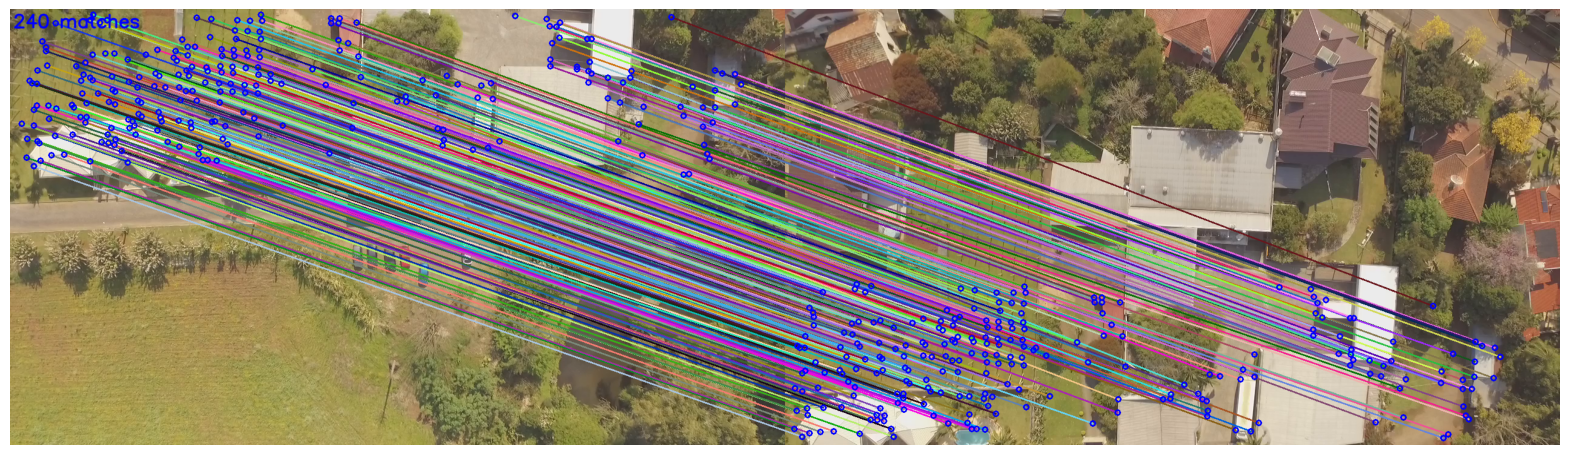

In [12]:
#test function for pair matching
def omniglue_pair_match_test(idx1, idx2):
    pos0, angle0, scale0 = get_ground_truth_adm(idx1)
    pos, angle, scale = get_ground_truth_adm(idx2)
    dp, pos_pred, da, ds, _, _ = pair_match_omni(get_tframe_omni(idx1), get_tframe_omni(idx2), pos0, angle0, scale0)
    print(f'mathes idxes: {idx1, idx2}')
    print(f'pos before: {pos0}; pos truth: {pos}; predict: {pos0+dp}')
    print(f'angle before: {angle0}; angle truth: {angle}; predict: {angle0 + da}')
    print(f'scale before: {scale0}; scale truth: {scale}; predict: {scale0+ds}')
    print(f'ERRORS : \n\taed_pos (pix) = {np.linalg.norm(pos_pred - pos):.0f}, aed_pos (m) = {np.linalg.norm(pos_pred - pos)*MAP_GSD}\n\tangle_error = {angle - (angle0+da)}\n\tscale_error = {scale - (scale0+ds)}')
    print('________________________________')


omniglue_pair_match_test(1, 15)


In [17]:

def map_match_omniglue(map, frame, pos, angle, scale, Kk):
    posX, posY = int(pos[0]), int(pos[1])

    h, w = frame.shape[:2]
    new_size = (round(w * scale), round(h * scale))

    #Create and tranform mask
    mask = np.ones((h, w), dtype=np.uint8) * 255
    mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)
    M = cv2.getRotationMatrix2D((new_size[0]/2, new_size[1]/2), -90-angle, 1)
    mask = cv2.warpAffine(mask, M, new_size)

    #transform the image from UAV
    frame = cv2.resize(frame, new_size)
    frame = cv2.warpAffine(frame, M, new_size)

    #determining the size and boundaries of a map area
    rW = int(new_size[0] * Kk / 2)
    rH = int(new_size[1] * Kk / 2)

    px0 = max(posX - rW, 0)
    px1 = min(posX + rW, map.shape[1])
    py0 = max(posY - rH, 0)
    py1 = min(posY + rH, map.shape[0])

    #masking
    chunk = map[py0:py1, px0:px1]
    mask = cv2.resize(mask, (px1-px0, py1-py0), interpolation=cv2.INTER_NEAREST)
    mask = mask[..., None] //255
    chunk = chunk * mask

    #image matching
    match_kp0s, match_kp1s, match_confidences = og.FindMatches(chunk, frame)

    num_matches = match_kp0s.shape[0]
    if num_matches < 6:
        return 0, 0, pos, 0, 0, 0, 0
    keep_idx = []

    for i in range(match_kp0s.shape[0]):
        if match_confidences[i] > match_threshold:
            keep_idx.append(i)

    match_kp0 = match_kp0s[keep_idx]
    match_kp1 = match_kp1s[keep_idx]
    match_confidences = match_confidences[keep_idx]
    num_filtered_matches = len(keep_idx)

    #keypoint filtering
    affine_mat, inliers = cv2.estimateAffine2D(match_kp0, match_kp1, method=cv2.RANSAC,  ransacReprojThreshold=10.0, confidence=0.95)
    N0 = np.sum(inliers)

    m_kpts0 = []
    m_kpts1 = []
    for i in range(len(inliers)):
        if inliers[i]>0:
            m_kpts0.append(match_kp0[i])
            m_kpts1.append(match_kp1[i])

    m_kpts0 = np.array(m_kpts0)
    m_kpts1 = np.array(m_kpts1)

    if N0 < 6:
        return 0, 0, pos, 0, 0, 0, 0

    #linear regression for prediction
    frame_center = np.array([[frame.shape[1] / 2, frame.shape[0] / 2]] * N0)
    X, Y = (m_kpts1 - frame_center), m_kpts0

    model = None
    model = RANSACRegressor(estimator=LinearRegression(), min_samples=5)
    model.fit(X, Y)
    v = model.predict(np.array([[0, 0]]))
    v = (v[0, 0], v[0, 1])

    #predict position
    dp = np.array([0, 0]) - (rW, rH) + v
    dp = np.clip(pos + dp, 0, map.shape[0])-pos

    #predict angle
    da = np.degrees(-np.arctan2(affine_mat[1, 0], affine_mat[0, 0]))
    angle_pred = angle+da

    #predict scale
    k = np.abs(np.linalg.det(model.estimator_.coef_[0:2, 0:2]))
    k = k / np.abs(k) * np.sqrt(np.abs(np.linalg.det(model.estimator_.coef_)))
    ds = scale * (np.abs(k) - 1)/Kk

    #vizualize_omni(chunk, frame, match_kp0, match_kp1, num_filtered_matches)
    del mask, chunk

    return np.linalg.norm(dp), dp , pos+dp, da, ds, inliers, N0


IDX = 233
pos_before: [3374. 2014.]; pos truth: [3397. 2011.]; predict: [3361.16148379 1985.46876334]; dp: [-12.83851621 -28.53123666]
angle_before: -20.9259; angle truth: -21.2823; predict: -8.965853087583625; da = 11.960046912416374, angle_error = -12.316446912416374
scale_before: 0.5955157031; scale truth: 0.5956221875; predict: 0.7112062105173748, ds = 0.11569050741737479, scale_error = -0.1155840230173748 
ERRORS : 
	aed_pos (pix) = 44, aed_pos (m) = 10.634001438347525
	angle_error = -12.316446912416374
	scale_error = -0.1155840230173748
________________________________


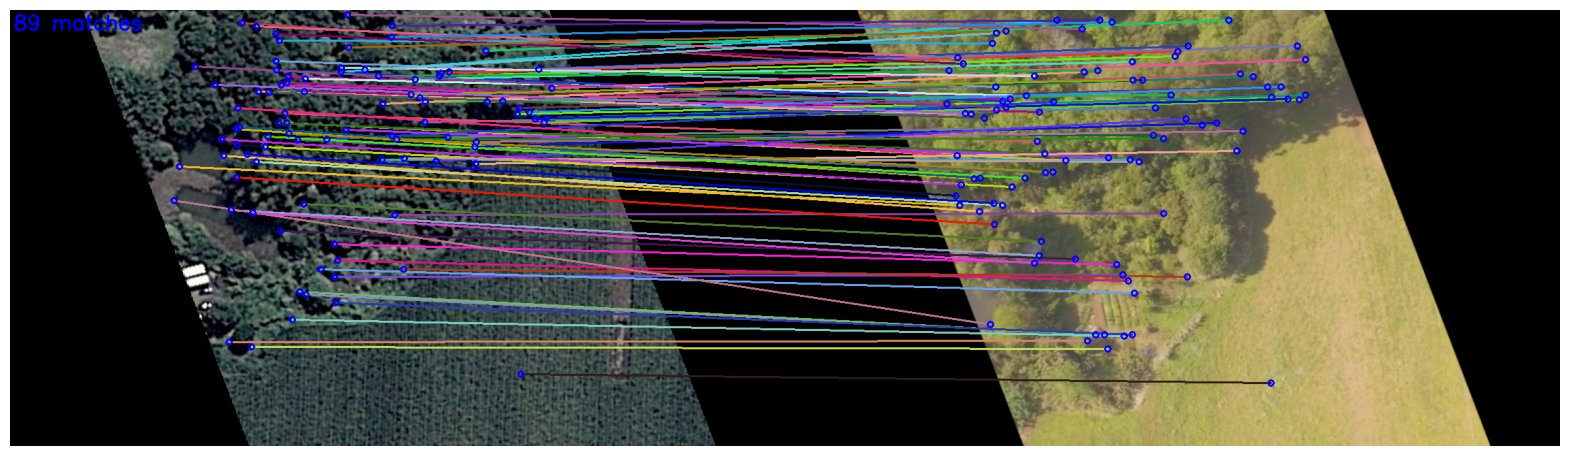

In [16]:
#test function to map matching
def omniglue_map_match_test(idx):
    pos, angle, scale = get_ground_truth_adm(idx-1)
    pos0, angle0, scale0 = get_ground_truth_adm(idx)
    print(f'IDX = {idx}')
    aed, dp, pos_pred, da, ds, inliers, outliers = map_match_omniglue(MAP, get_tframe_omni(idx), pos, angle, scale, 1.5)
    print(f'pos_before: {pos}; pos truth: {pos0}; predict: {pos_pred}; dp: {dp}')
    print(f'angle_before: {angle}; angle truth: {angle0}; predict: {angle+da}; da = {da}, angle_error = {angle0 - (angle+da)}')
    print(f'scale_before: {scale}; scale truth: {scale0}; predict: {scale+ds}, ds = {ds}, scale_error = {scale0 - (scale+ds)} ')
    print(f'ERRORS : \n\taed_pos (pix) = {np.linalg.norm(pos_pred - pos0):.0f}, aed_pos (m) = {np.linalg.norm(pos_pred - pos0)*MAP_GSD}\n\tangle_error = {angle0 - (angle+da)}\n\tscale_error = {scale0 - (scale+ds)}')
    print('________________________________')

omniglue_map_match_test(random.randint(1, 357))

100%|██████████| 358/358 [20:51<00:00,  3.50s/it]


Zoom K: 1.0
average position: 31.423502506748452 pix
average position: 7.594013105797543 m


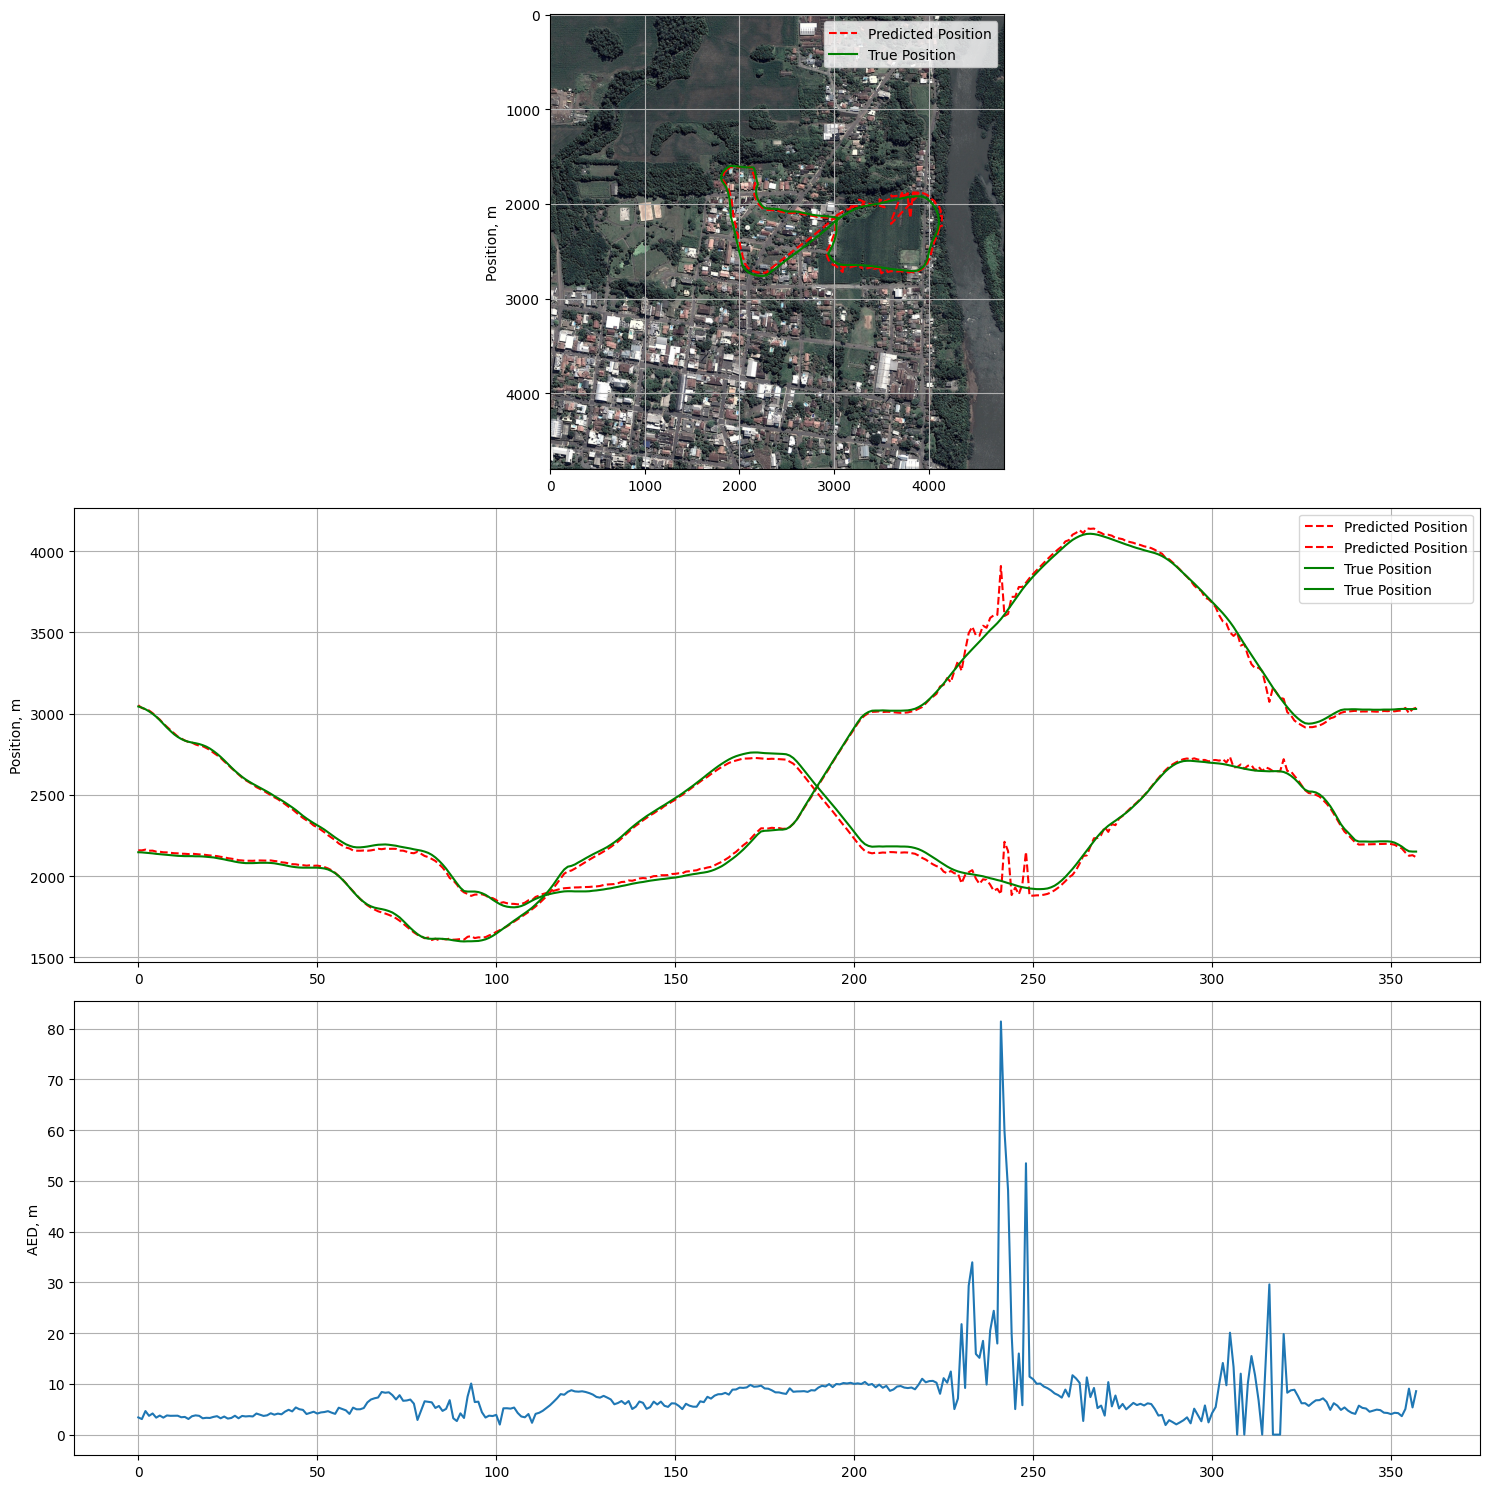

100%|██████████| 358/358 [14:44<00:00,  2.47s/it]


Zoom K: 1.5
average position: 34.46314580210768 pix
average position: 8.32859356884269 m


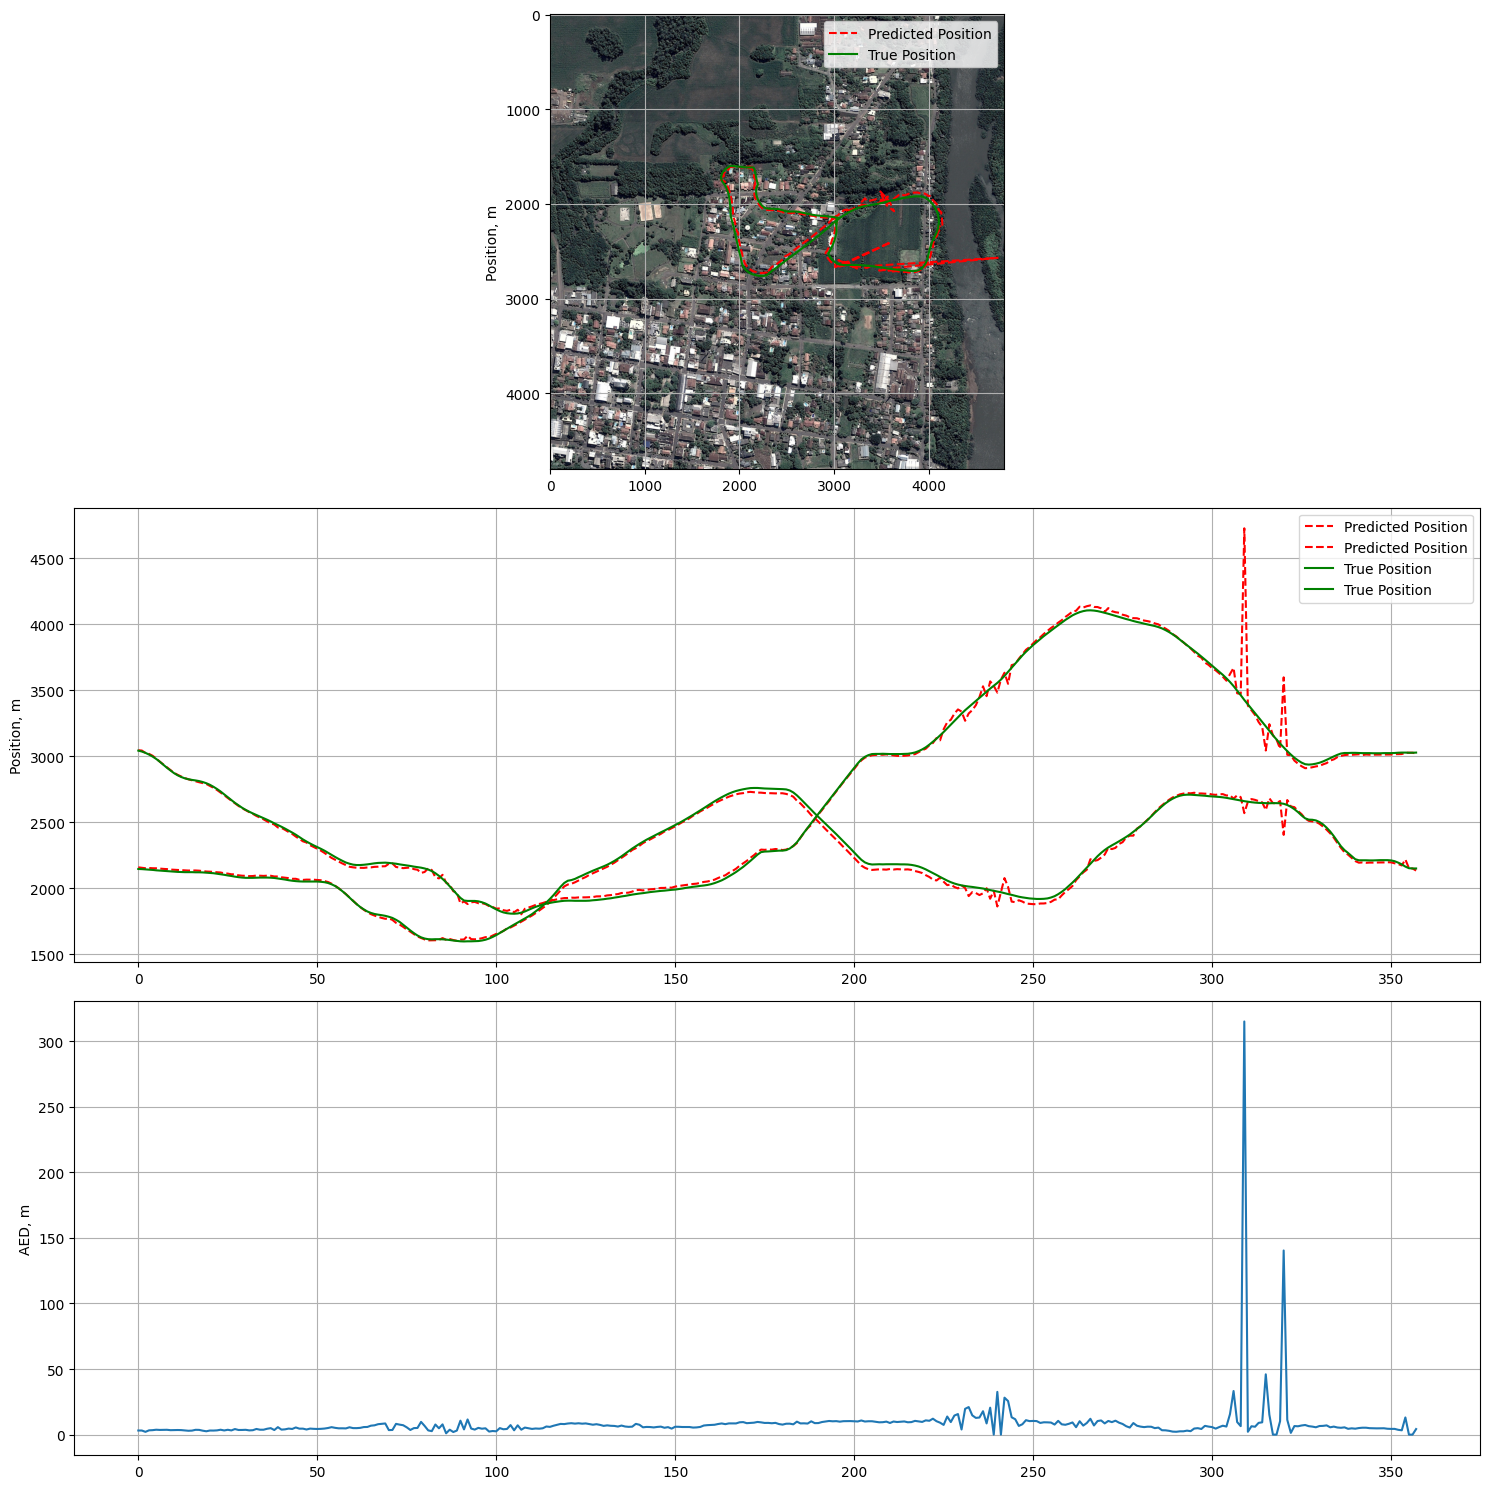

100%|██████████| 358/358 [16:11<00:00,  2.71s/it]


Zoom K: 2.0
average position: 46.43262929744397 pix
average position: 11.221218746882291 m


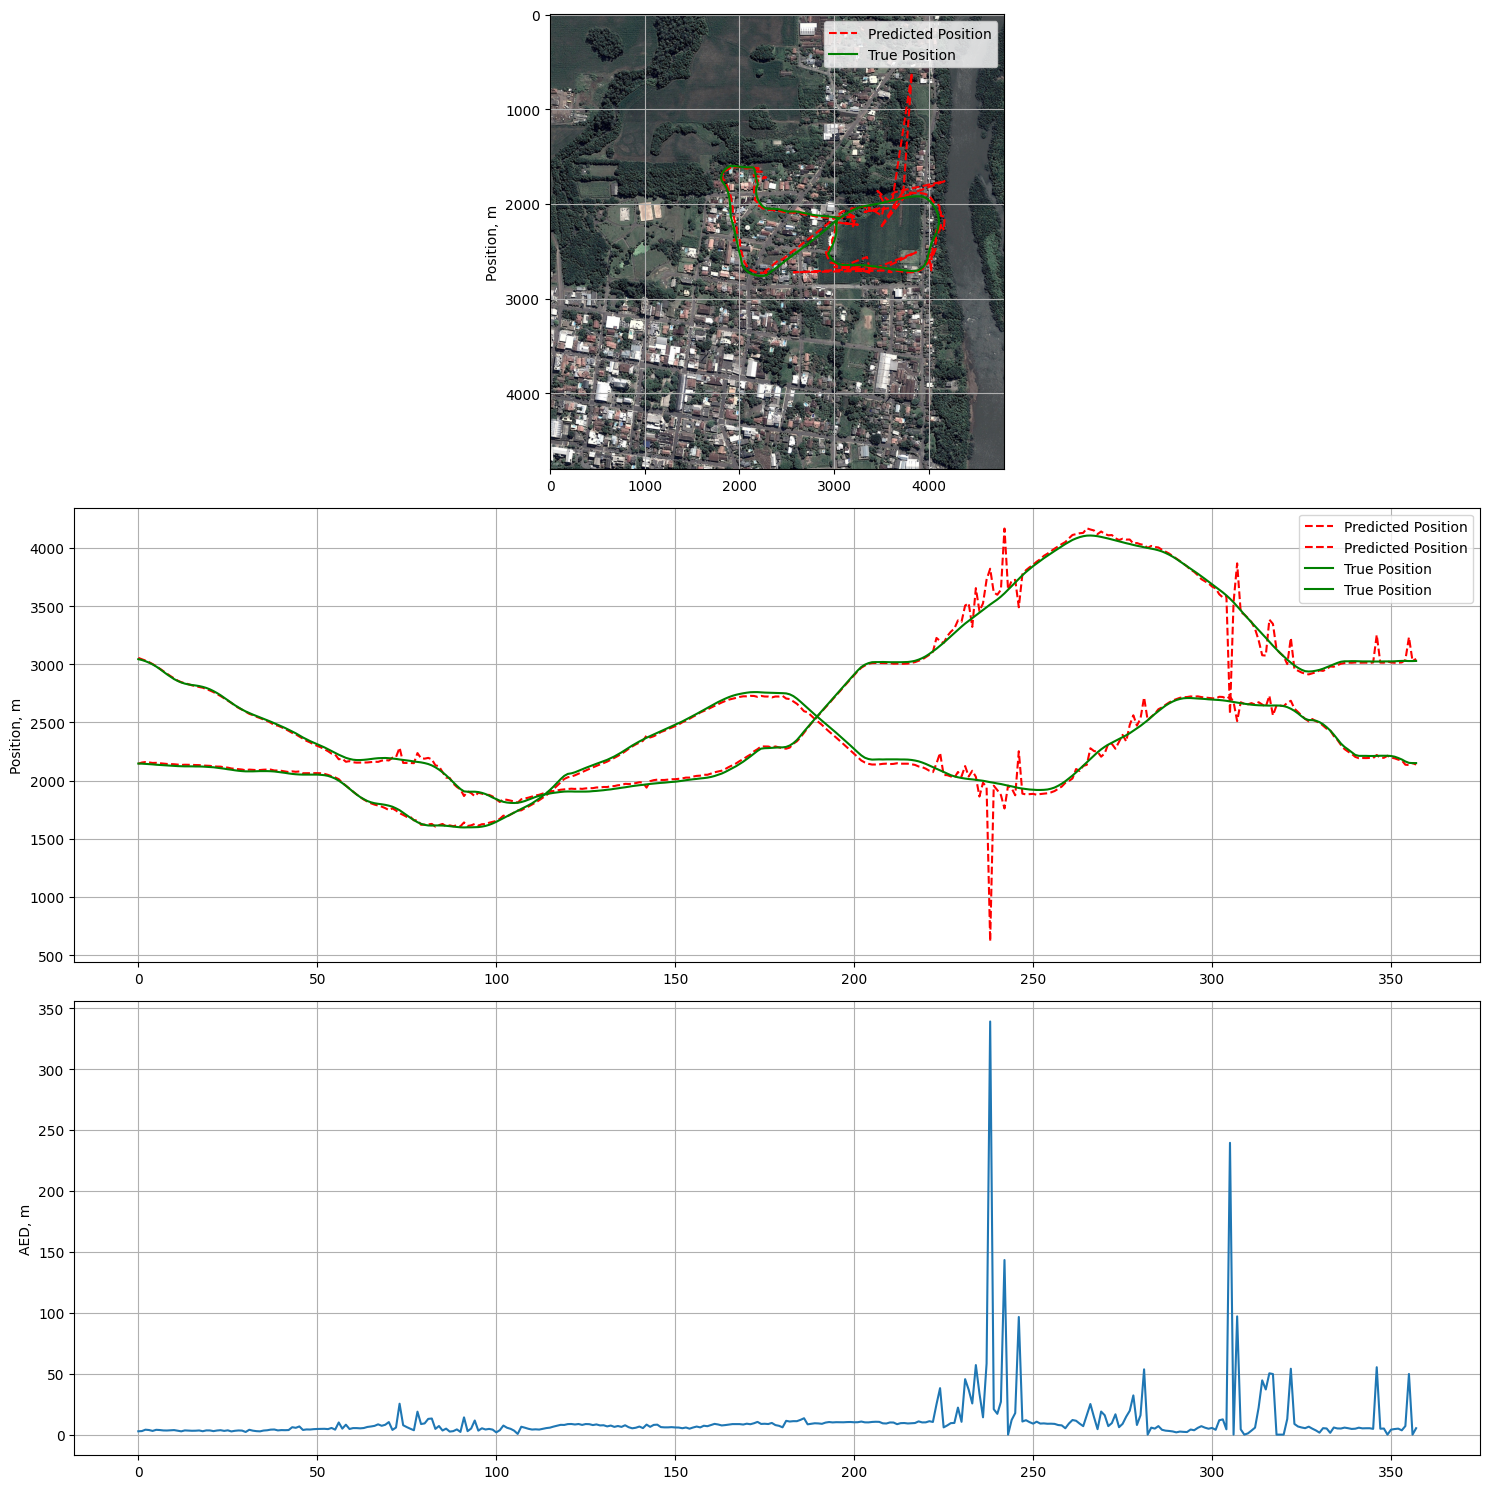

 32%|███▏      | 116/358 [05:18<21:13,  5.26s/it]

In [ ]:
#test map matching at different scale factors with known coordinates

Ks = [1.0, 1.5, 2.0, 2.5, 3.0]
TMAP = get_tmap_omni(MAP_NAME)

averages_m = []
averages_pix = []
time_mean = []

for Kk in Ks:
    plt.figure(figsize=(15,15))
    predict_pos_s = []
    aed_s = []
    inliers = []
    outliers = []

    for idx in tqdm(range(FRAMES_NUM)):

        pos, angle, scale = get_ground_truth_adm(idx)
        start = time.time()
        with torch.no_grad():
            aed, dp, predict_pos, da, ds, inlier, otlier = map_match_omniglue(TMAP, get_tframe_omni(idx), pos, angle, scale, Kk)
        if aed is None:
            aed_s.append(aed)
            predict_pos_s.append(predict_pos)
            inliers.append(inlier)
            outliers.append(outliers)
            continue

        aed_s.append(aed)
        predict_pos_s.append(predict_pos)
        inliers.append(inlier)
        outliers.append(outliers)

    print(f'Zoom K: {Kk}')


    print(f'average position: {sum(aed_s)/len(aed_s)} pix')
    averages_pix.append(sum(aed_s)/len(aed_s))

    print(f'average position: {sum(aed_s)/len(aed_s)*MAP_GSD} m')
    averages_m.append(sum(aed_s)/len(aed_s)*MAP_GSD)

    position = np.array(TRUE_PS)
    predict_position = np.array(predict_pos_s)
    # Первый график (позиция)
    plt.subplot(3, 1, 1)
    plt.imshow(MAP)
    plt.plot(predict_position[:, 0], predict_position[:, 1], 'r--', label='Predicted Position')
    plt.plot(position[:, 0], position[:, 1], 'g-', label='True Position')
    plt.ylabel("Position, m")
    plt.legend()
    plt.grid()

    # Второй график (позиция)
    plt.subplot(3, 1, 2)
    plt.plot(predict_position, 'r--', label='Predicted Position')
    plt.plot(position, 'g-', label='True Position')
    plt.ylabel("Position, m")
    plt.legend()
    plt.grid()

    # Второй график (AED)
    plt.subplot(3, 1, 3)
    plt.plot(np.array(aed_s)*MAP_GSD)
    plt.ylabel("AED, m")
    plt.grid()



    # Улучшаем компоновку
    plt.tight_layout()  # Это предотвращает наложение подписей
    plt.show()

averages_pix = [31.074260170061244, 36.20351388370154, 43.720168974282, 85.13241482189264]
averages_m = [7.509612874431467, 8.74918252189454, 10.56570750211815, 20.573666915290723]



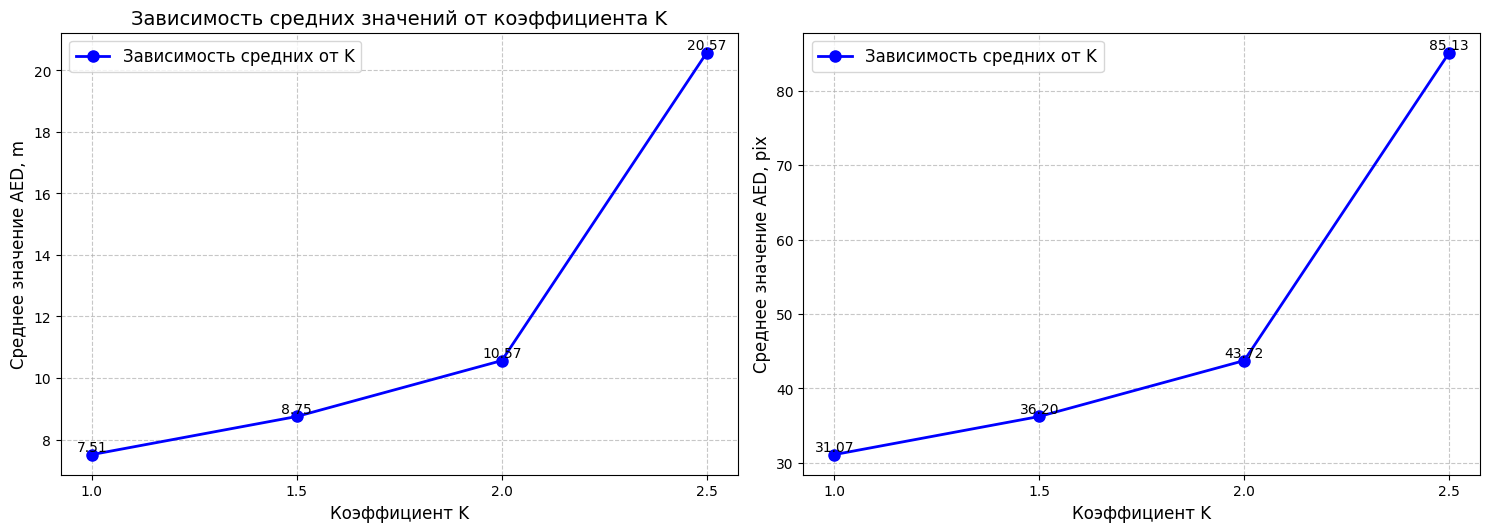

In [20]:

averages_pix = [31.074260170061244, 36.20351388370154, 43.720168974282, 85.13241482189264]
averages_m = [7.509612874431467, 8.74918252189454, 10.56570750211815, 20.573666915290723]
time_mean = [4.07676491040862, 2.5514480375044837, 2.7562820194812305, 2.720654963781048]
Ks = [1.0, 1.5, 2.0, 2.5]

print(f'averages_pix = {averages_pix}\naverages_m = {averages_m}\n')
plt.figure(figsize=(15, 10))

# Основной график (линия + точки)
plt.subplot(2, 2, 1)
plt.plot(Ks, averages_m, 'bo-', linewidth=2, markersize=8, label='Зависимость средних от K')

# Дополнительные элементы
plt.title('Зависимость средних значений от коэффициента K', fontsize=14)
plt.xlabel('Коэффициент K', fontsize=12)
plt.ylabel('Среднее значение AED, m', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Подписи точек
for k, avg in zip(Ks, averages_m):
    plt.text(k, avg, f'{avg:.2f}', ha='center', va='bottom', fontsize=10)

# Легенда и оформление
plt.legend(fontsize=12)
plt.xticks(Ks)  # Обеспечиваем метки для всех значений K
plt.tight_layout()


plt.subplot(2, 2, 2)
plt.plot(Ks, averages_pix, 'bo-', linewidth=2, markersize=8, label='Зависимость средних от K')

# Дополнительные элементы
plt.xlabel('Коэффициент K', fontsize=12)
plt.ylabel('Среднее значение AED, pix', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Подписи точек
for k, avg in zip(Ks, averages_pix):
    plt.text(k, avg, f'{avg:.2f}', ha='center', va='bottom', fontsize=10)

# Легенда и оформление
plt.legend(fontsize=12)
plt.xticks(Ks)  # Обеспечиваем метки для всех значений K
plt.tight_layout()



# Показать график
plt.show()

In [22]:
#flight simulating function
def fly(pos0, angle0, scale0, idx_start):
    position = []
    pos_MM = []
    pos_PM = []
    pos_err = []
    angle_err = []
    scale_err = []

    Kk = 1.5


    #getting initial coordinates
    pos_now = pos0
    angle_now = angle0
    scale_now = scale0

    position.append(pos_now)
    pos_MM.append(pos_now)
    pos_PM.append(pos_now)
    #start fly
    img_past = get_tframe_omni(idx_start)
    for idx in tqdm(range(100, 200)):

        img = get_tframe_omni(idx)

        true_pos, true_angle, true_scale = get_ground_truth_adm(idx)

        #map matching
        aed_MM, dp_MM, pos_pred_MM, da_MM, ds_MM, inliers_MM, outliers_MM = map_match_omniglue(get_tmap_omni(MAP_NAME), img, pos_now, angle_now, scale_now, Kk)
        torch.cuda.empty_cache()

        #pair matching with past image
        dp_PM, pos_pred_PM, da_PM, ds_PM, inliers_PM, outliers_PM = pair_match_omni(img_past, img, pos_now, angle_now, scale_now)
        torch.cuda.empty_cache()

        pos_MM.append(pos_pred_MM)
        pos_PM.append(pos_pred_PM)

        #combination of methods results
        if (aed_MM == 0):
            pos_now = pos_pred_PM
            angle_now = (angle_now + da_PM + 180) %360 - 180
            scale_now = scale_now +ds_PM
        else:
            pos_now = (pos_pred_MM + pos_pred_PM)/2
            angle_now = (angle_now + (da_MM + da_PM)/2 + 180) %360 - 180
            scale_now = scale_now + (ds_MM + ds_PM)/2

        position.append(pos_now)

        img_past = img  # Явное копирование без градиентов
        del img
        torch.cuda.empty_cache()
        #print(f'TRUE POS: {true_pos}; predict POS: {pos_now}; POS error: {np.linalg.norm(true_pos - pos_now)}')
        pos_err.append(np.linalg.norm(true_pos - pos_now))
        angle_err.append(true_angle - angle_now)
        scale_err.append(true_scale - scale_now)

    return position, pos_err, angle_err, scale_err, pos_MM, pos_PM

In [23]:
#start fly imitation
pos0, angle0, scale0 = get_ground_truth_adm(99)
position, pos_err, angle_err, scale_err, pos_MM, pos_PM = fly(pos0, angle0, scale0, 99)

100%|██████████| 100/100 [12:05<00:00,  7.26s/it]


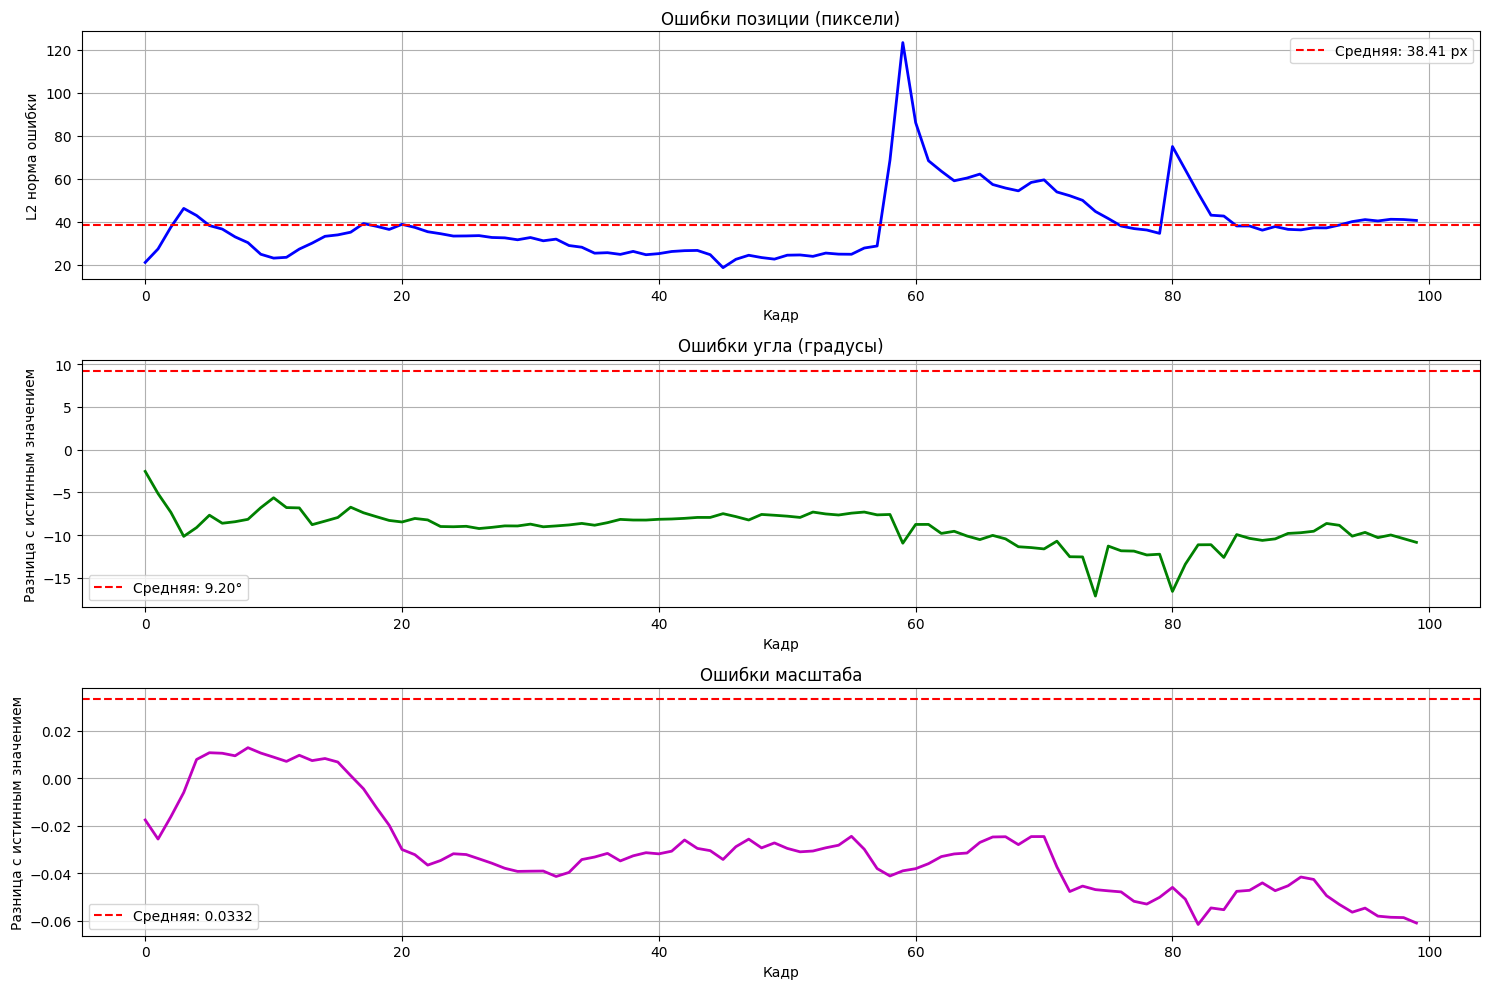


Статистика ошибок:
Позиция: средняя = 38.41 px, max = 123.34 px
Угол: средняя = 9.20°, max = 17.13°
Масштаб: средняя = 0.0332, max = 0.0616


In [24]:
#visualize results
plt.figure(figsize=(15, 10))

    # График ошибок позиции
plt.subplot(3, 1, 1)
plt.plot(pos_err, 'b-', linewidth=2)
plt.title('Ошибки позиции (пиксели)')
plt.xlabel('Кадр')
plt.ylabel('L2 норма ошибки')
plt.grid(True)

# Добавляем среднюю ошибку
avg_pos_err = np.mean(pos_err)
plt.axhline(y=avg_pos_err, color='r', linestyle='--',
            label=f'Средняя: {avg_pos_err:.2f} px')
plt.legend()

# График ошибок угла
plt.subplot(3, 1, 2)
plt.plot(angle_err, 'g-', linewidth=2)
plt.title('Ошибки угла (градусы)')
plt.xlabel('Кадр')
plt.ylabel('Разница с истинным значением')
plt.grid(True)

avg_angle_err = np.mean(np.abs(angle_err))
plt.axhline(y=avg_angle_err, color='r', linestyle='--',
            label=f'Средняя: {avg_angle_err:.2f}°')
plt.legend()

# График ошибок масштаба
plt.subplot(3, 1, 3)
plt.plot(scale_err, 'm-', linewidth=2)
plt.title('Ошибки масштаба')
plt.xlabel('Кадр')
plt.ylabel('Разница с истинным значением')
plt.grid(True)

avg_scale_err = np.mean(np.abs(scale_err))
plt.axhline(y=avg_scale_err, color='r', linestyle='--',
            label=f'Средняя: {avg_scale_err:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод статистики
print("\nСтатистика ошибок:")
print(f"Позиция: средняя = {avg_pos_err:.2f} px, max = {np.max(pos_err):.2f} px")
print(f"Угол: средняя = {avg_angle_err:.2f}°, max = {np.max(np.abs(angle_err)):.2f}°")
print(f"Масштаб: средняя = {avg_scale_err:.4f}, max = {np.max(np.abs(scale_err)):.4f}")

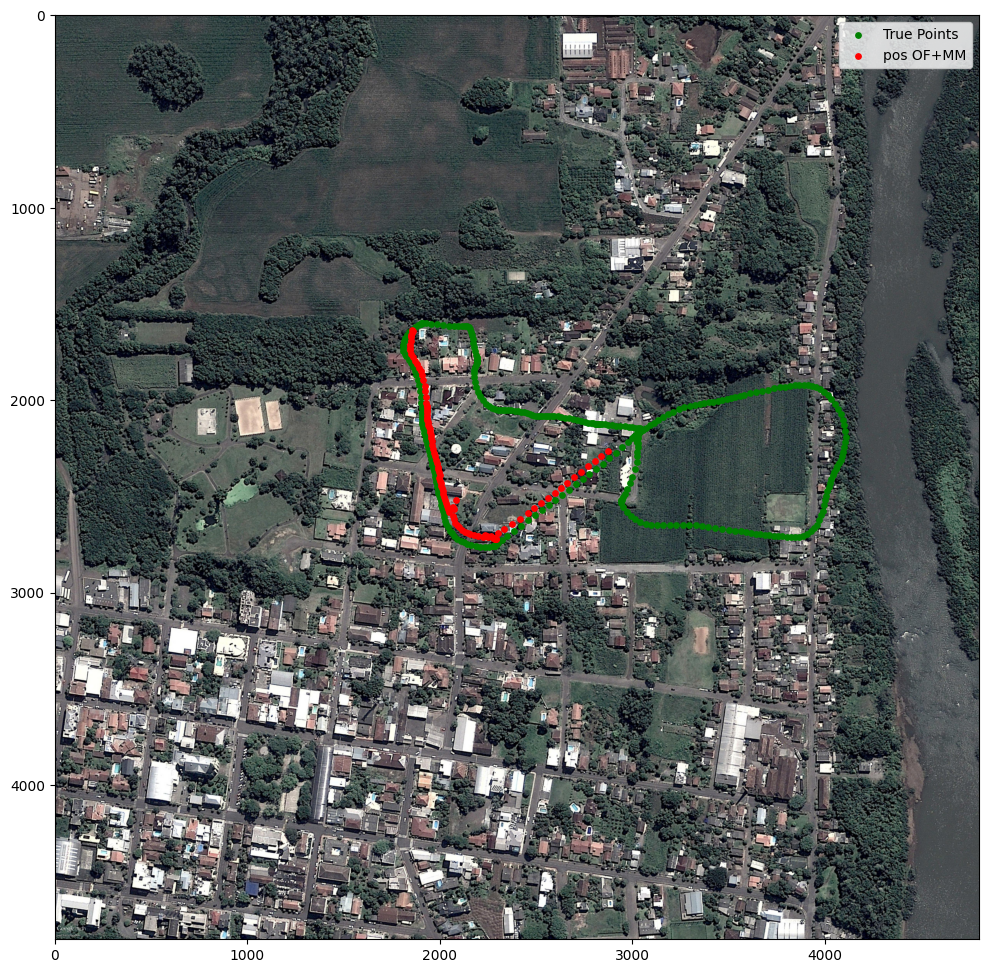

In [26]:
#visualize results on map
position = np.array(position)

plt.figure(figsize=(12, 12))
plt.imshow(MAP)

# TRUE_PS (N, 2) — уже правильно
plt.scatter(TRUE_PS[:, 0], TRUE_PS[:, 1], s=15, c='green', label='True Points')

# pos_MM (N, 2) — рисуем все точки
plt.scatter(position[:,0], position[:,1], s=15, c='red', label='pos OF+MM')

# pos_PM (N, 2) — рисуем все точки
#plt.scatter(pos_PM[:,0], pos_PM[:,1], s=40, c='green', marker='o', label='PM Positions')

plt.legend()
plt.show()